In [1]:
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

In [2]:
import os
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone_topo import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math



8


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # 计算额外的一个元素以适应奇数维度
        div_term = torch.exp(torch.arange(0, d_model + 1, 2).float() * (-math.log(10000.0) / d_model))
        # 使用切片确保不会溢出
        pe[:, 0::2] = torch.sin(position * div_term[:d_model // 2 + 1])
        pe[:, 1::2] = torch.cos(position * div_term[:d_model // 2])

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(0), :].unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + pe
        return x




class EEGAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(EEGAttention, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.d_model = d_model

    def forward(self, src):
        src = src.permute(2, 0, 1)  # Change shape to [time_length, batch_size, channel]
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output.permute(1, 2, 0)  # Change shape back to [batch_size, channel, time_length]

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 


class Padding(nn.Module):
    def __init__(self):
        super(Padding, self).__init__()
        self.region_to_electrodes = {
            'Frontal': ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8'],
            'Central': ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'],
            'Parietal': ['CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
            'Temporal': ['FT9', 'FT7', 'T7', 'TP9', 'TP7', 'TP8', 'TP10', 'T8', 'FT8', 'FT10'],
            'Occipital': ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2'],
            # 'Whole_brain': ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8',
            #                 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
            #                 'FT9', 'FT7', 'T7', 'TP9', 'TP7', 'TP8', 'TP10', 'T8', 'FT8', 'FT10',
            #                 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
            #                 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
            'Whole_brain': ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3',
				  'F1', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 
				  'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T7', 'C5', 'C3', 'C1',
				  'Cz', 'C2', 'C4', 'C6', 'T8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 
				  'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1',
				  'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8',
				  'O1', 'Oz', 'O2']
        }

    def forward(self, x, region_name):
        # 获取全脑电极通道的数量
        num_total_electrodes = len(self.region_to_electrodes['Whole_brain'])
        # 初始化一个全0的补全矩阵
        x_padded = torch.zeros(x.size(0), num_total_electrodes, x.size(2), device=x.device)
        # 获取当前区域的电极列表
        current_region_electrodes = self.region_to_electrodes.get(region_name, [])
        # 获取当前区域电极在全脑电极列表中的索引
        electrode_indices = [self.region_to_electrodes['Whole_brain'].index(e) for e in current_region_electrodes]
        # 对于部分脑区的输入，只在对应的电极位置填充数据
        for idx, electrode_idx in enumerate(electrode_indices):
            x_padded[:, electrode_idx, :] = x[:, idx, :]
        return x_padded


class ATMS(nn.Module):    
    def __init__(self, num_channels=63, sequence_length=250, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(ATMS, self).__init__()
        self.attention_model = EEGAttention(num_channels, nhead=1)   
        self.subject_wise_linear = nn.ModuleList([nn.Linear(sequence_length, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()       
        self.padding = Padding()

    def forward(self, x, region_name):
        x = self.padding(x, region_name)

        x = self.attention_model(x)
        x = self.subject_wise_linear[0](x)
        eeg_embedding = self.enc_eeg(x)
        
        out = self.proj_eeg(eeg_embedding)
        return out


    


def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k, mode):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0
    # 获取所有独特的类别
    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)            
            
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data, 'Occipital').float()
            
            features_list.append(eeg_features)
            logit_scale = eegmodel.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):
                # 先从除了正确类别之外的类别中选择 k-1 个
                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                
                # 计算对应的 logits
                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)
                # 获取预测的类别
                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1
        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            # print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"masked_ATM_S_eeg_features_Occipital_{sub}_{mode}.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()


from IPython.display import Image, display
config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1024,
"logger": True,
"encoder_type":'ATM_S_reconstruction_scale_0_1000',
}

 
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# 获取数据路径
data_path = config['data_path']
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')
# 模型和优化器定义
eeg_model = ATMS(63, 250)
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

#####################################################################################
# 确定使用的设备
# eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/contrast/sub-08/01-30_00-44/40.pth"))
eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/BrainAligning_retrieval/models/masked_areas/ATMS/sub-08/02-21_13-19/40.pth"))
eeg_model.to(device)
sub = 'sub-08'

#####################################################################################

test_dataset = EEGDataset("Occipital", data_path, subjects= [sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
test_loss, test_accuracy,labels, eeg_features_test = get_eegfeatures(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all,k=200, mode="test")
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



number of parameters: 3246741
self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 8, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
 - Test Loss: 15.8447, Test Accuracy: 0.2150


In [4]:
# #####################################################################################
# train_dataset = EEGDataset("Occipital", data_path, subjects= [sub], train=True)
# train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
# text_features_test_all = train_dataset.text_features
# img_features_test_all = train_dataset.img_features

# train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200, mode="train")
# print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
# #####################################################################################


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
from custom_pipeline import *
# os.environ["CUDA_VISIBLE_DEVICES"] = "5" 


# 设置device为显存容量最大的GPU设备

device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

Load eeg and image embeddings

In [6]:
# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_test.pt', map_location='cuda:3')
# emb_img_test = data['img_features']

# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_train.pt', map_location='cuda:3')
# emb_img_train = data['img_features']

In [7]:
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')


In [8]:
emb_img_test.shape, emb_img_train.shape

(torch.Size([200, 1024]), torch.Size([16540, 1024]))

In [9]:
# 定义需要加载的其他脑区名称
regions = ['Frontal', 'Central', 'Parietal', 'Temporal', 'Occipital', 'Whole_brain']
# 循环加载所有脑区的特征
for i, region in enumerate(regions):
    # 构建训练集和测试集的文件路径
    train_file_path = f'/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_{region}_sub-08_train.pt'
    test_file_path = f'/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_{region}_sub-08_test.pt'
    
    # 加载特征
    emb_eeg_region = torch.load(train_file_path)
    emb_eeg_test_region = torch.load(test_file_path)
    
    # 如果是第一个脑区，直接赋值给emb_eeg和emb_eeg_test
    if i == 0:
        emb_eeg = emb_eeg_region
        emb_eeg_test = emb_eeg_test_region
    else:
        # 将加载的特征合并到emb_eeg和emb_eeg_test中
        emb_eeg = torch.cat((emb_eeg, emb_eeg_region), dim=0)  # 假设特征在第一个维度上合并
        emb_eeg_test = torch.cat((emb_eeg_test, emb_eeg_test_region), dim=0)

In [10]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([396960, 1024]), torch.Size([1200, 1024]))

Training prior diffusion

In [11]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }


In [12]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)
emb_img_train_expanded = emb_img_train_4.repeat(6, 1)

In [13]:
emb_img_train_expanded.shape

torch.Size([396960, 1024])

In [14]:
# path_data = '/mnt/dataset0/weichen/projects/visobj/proposals/mise/data'
# image_features = torch.load(os.path.join(path_data, 'openclip_emb/emb_imgnet.pt')) # 'emb_imgnet' or 'image_features'
# h_embeds_imgnet = image_features['image_features']

In [15]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_expanded, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

396960


In [16]:
# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [17]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.diffusion_prior.load_state_dict(torch.load(f'./ckpts/masked_{model_name}_oneprior.pt', map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/masked_{model_name}_oneprior.pt')

<All keys matched successfully>

In [18]:
# 1654clsx10imgsx4trials=66160
# emb_eeg = torch.load('/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_Occipital_sub-08_train.pt')

emb_eeg_test = torch.load('/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_Occipital_sub-08_test.pt')

In [19]:
from IPython.display import Image, display
generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_embeds torch.Size([1, 1024])


  0%|          | 0/4 [00:00<?, ?it/s]

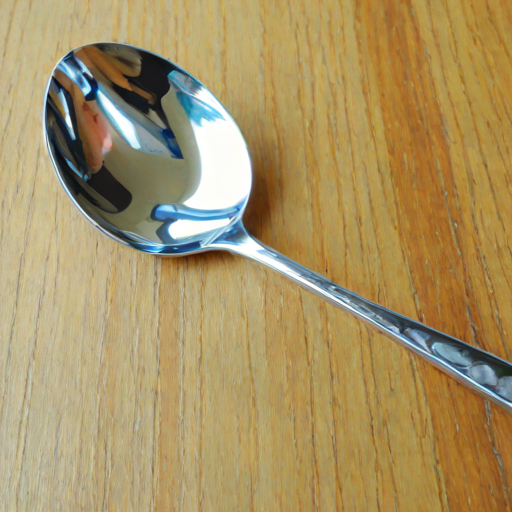

  0%|          | 0/4 [00:00<?, ?it/s]

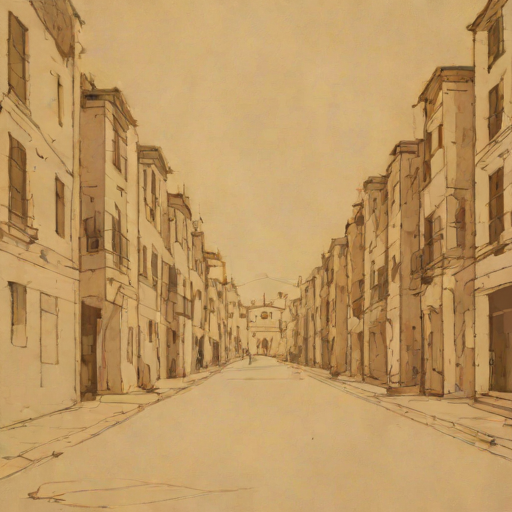

image_embeds torch.Size([1, 1024])


50it [00:00, 262.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

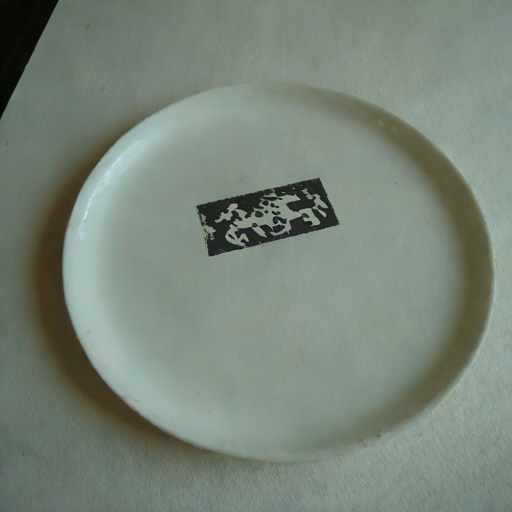

In [20]:
# 设定一个种子值
seed_value = 42

# 设置全局种子
torch.manual_seed(seed_value)

# 如果在GPU上运行，还需要设置CUDA种子
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

# from IPython.display import Image, display
# generator = Generator4Embeds(num_inference_steps=4, device=device)


# path of ground truth: /home/ldy/Workspace/THINGS/images_set/test_images
k = 170
image_embeds = emb_img_test[k:k+1]
print("image_embeds", image_embeds.shape)
# 创建一个特定的随机数生成器实例，并为其设置种子
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(image_embeds, generator=gen)
display(image)


gen.manual_seed(seed_value)
image = generator.generate(emb_eeg_test[k:k+1], generator=gen)
display(image)


# k = 0
gen.manual_seed(seed_value)
eeg_embeds = emb_eeg_test[k:k+1]
print("image_embeds", eeg_embeds.shape)
h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0,generator=gen)
image = generator.generate(h.to(dtype=torch.float16), generator=gen)
display(image)

In [21]:
import os
import torch

# Assuming `generator`, `pipe`, and `emb_eeg_test` are predefined and properly set up
# `device` should also be defined (e.g., 'cuda' or 'cpu')

def create_dirs(base_dir, subdirs):
    os.makedirs(base_dir, exist_ok=True)
    for subdir in subdirs:
        dir_path = os.path.join(base_dir, str(subdir))
        os.makedirs(dir_path, exist_ok=True)

def generate_and_save_images(k_values, base_dir='THINGS', num_seeds=30):
    for k in k_values:
        k_dir = os.path.join(base_dir, str(k))
        eeg_embeds = emb_eeg_test[k:k+1]  # Assuming emb_eeg_test is indexed by k
        for seed in range(num_seeds):
            gen = torch.Generator(device=device).manual_seed(seed)
            h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0, generator=gen)
            image = generator.generate(h.to(dtype=torch.float16), generator=gen)
            
            # Assuming `image` is a PIL Image or similar; if it's a tensor, you'll need to convert it
            image_file = os.path.join(k_dir, f"{seed}.png")  # Save as PNG
            image.save(image_file)

# Create 'THIN GS' directory and subdirectories for given k values
k_values = [10, 11, 20, 58, 177, 93, 141, 160, 100, 108, 111, 115]
base_dir = 'THINGS/Occipital'
create_dirs(base_dir, k_values)

# Generate and save images
generate_and_save_images(k_values, base_dir)


50it [00:00, 202.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 204.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 204.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 204.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 202.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 202.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 204.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 202.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 120.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 202.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 204.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 205.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 206.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 262.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 263.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 261.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 256.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 262.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 262.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 258.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 260.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 260.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 260.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 118.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 263.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 261.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 262.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 260.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 193.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 201.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 256.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 138.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 135.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 258.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 259.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 259.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 225.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 258.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 257.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 186.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 187.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 189.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 188.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 188.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 188.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 187.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 132.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 227.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 216.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 142.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 188.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 189.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 213.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 256.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 256.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 201.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 201.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 201.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 192.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 201.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 118.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 114.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 194.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 194.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 193.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 199.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 142.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 255.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 189.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 193.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 252.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 229.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 187.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 186.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 109.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 186.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 193.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 195.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 229.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 189.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 192.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 192.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 198.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 135.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 211.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]